In [1]:
import pandas as pd
from geopy.geocoders import Photon
from geopy.geocoders import Nominatim
from unidecode import unidecode
import unidecode
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd
import seaborn as sns


import matplotlib.pyplot as plt

This study utilized multiple data sources including migration events data from the National Institute of Migration, support institutions data from both governmental and civil sectors, and criminal incidence data. Additionally, geographic datasets from GIS and customs and border protection were incorporated to map the real-time movements and dynamics of migratory routes across Mexican borders.



In [3]:
dfvalores = pd.read_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.csv')
#dfvalores = pd.read_csv('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv')

In [4]:
inm = pd.read_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\3.datos\\1. distribution_infraestructura\\1. Estaciones INM\\inm_gdp.csv')

In [5]:
dfvalores.head(2)

,ciudad,estado,region,id_poligon,codigo_uni,eventos,inm_30km,inm_in_gri,inm_in_est,eventos_ed,eventos_gr,sc_30km,promedio_s,sc_estado,geometry,distancia_metros,distancia_km
0,"Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,4,13,223058,113641,67,22.333333,117.0,POINT (-92.2609265 14.9042905),15537.0,15.537
1,"Huimanguillo, Tabasco",Tabasco,Golfo,PG1456,G-PG1456-1,86684.0,0,0,3,290299,86684,0,0.000000,43.0,POINT (-93.6634408051158 17.7620967),325527.0,325.527


C:\Users\puria\AppData\Local\Temp\ipykernel_13132\1143960539.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = dfvalores.groupby(['region', 'distancia_bin'])['eventos'].sum().reset_index()
C:\Users\puria\AppData\Local\Temp\ipykernel_13132\1143960539.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_data = binned_data.groupby('distancia_bin_num')['eventos'].mean().reset_index()


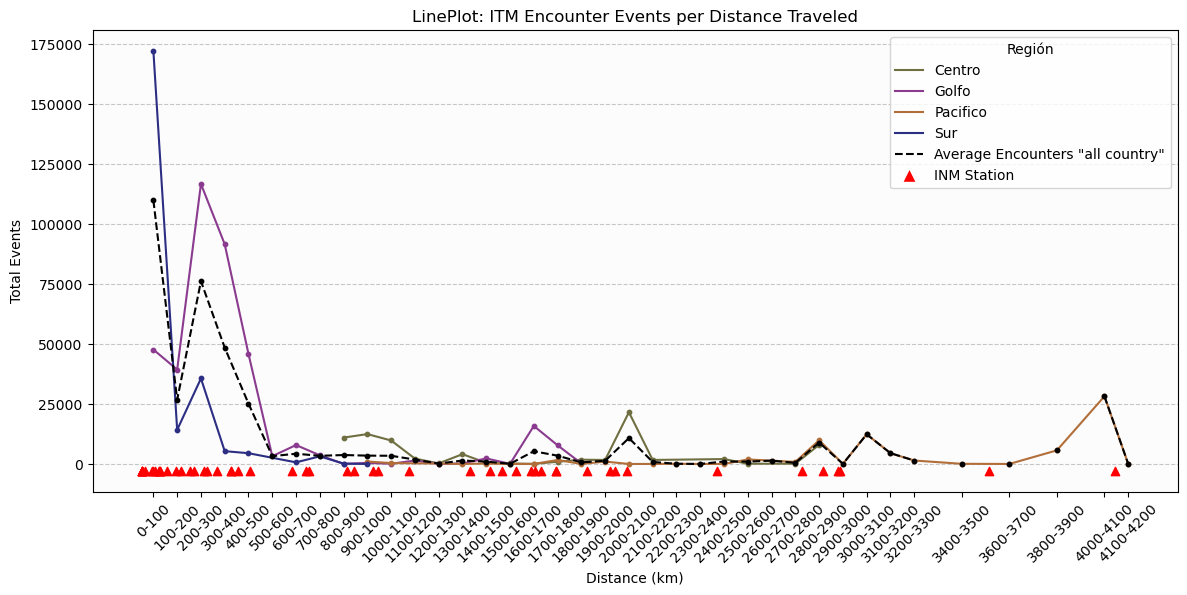

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir los colores específicos para cada región
colors = {
    'Golfo': '#8a3b8f',    # Morado
    'Centro': '#706f42',   # Verde oliva
    'Pacifico': '#b26e39', # Naranja
    'Sur': '#2c2e83'       # Azul oscuro
}

# Crear los bins de 100 km
bin_size = 100
bins = np.arange(0, dfvalores['distancia_km'].max() + bin_size, bin_size)
dfvalores['distancia_bin'] = pd.cut(dfvalores['distancia_km'], bins=bins)

# Sumar los eventos por bin y región
binned_data = dfvalores.groupby(['region', 'distancia_bin'])['eventos'].sum().reset_index()

# Filtrar los datos para eliminar los bins con valor 0
binned_data = binned_data[binned_data['eventos'] > 0]

# Crear una columna numérica representativa de los bins para mantener el orden
binned_data['distancia_bin_num'] = binned_data['distancia_bin'].apply(lambda x: x.left + bin_size / 2)

# Crear la figura y los ejes
plt.figure(figsize=(14, 6))

# Graficar cada región con un color diferente
for region in binned_data['region'].unique():
    subset = binned_data[binned_data['region'] == region]
    plt.plot(subset['distancia_bin_num'], subset['eventos'], label=region, color=colors[region], linestyle='-')
    plt.scatter(subset['distancia_bin_num'], subset['eventos'], color=colors[region], s=10, zorder=2)  # Cambiar tamaño del marcador

# Calcular el promedio de eventos por distancia
average_data = binned_data.groupby('distancia_bin_num')['eventos'].mean().reset_index()

# Agregar la línea de promedio al gráfico
plt.plot(average_data['distancia_bin_num'], average_data['eventos'], label='Average Encounters "all country"', color='black', linestyle='--')
plt.scatter(average_data['distancia_bin_num'], average_data['eventos'], color='black', s=10, zorder=2)  # Marcar los puntos promedio

# Añadir títulos y etiquetas
plt.title('LinePlot: ITM Encounter Events per Distance Traveled')
plt.xlabel('Distance (km)')
plt.ylabel('Total Events')
plt.legend(title='Region')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar los ticks del eje x
plt.xticks(ticks=binned_data['distancia_bin_num'].unique(), labels=[f'{int(x.left)}-{int(x.right)}' for x in binned_data['distancia_bin'].unique()], rotation=45)

# Añadir un fondo gris con transparencia
plt.gca().patch.set_facecolor('gray')
plt.gca().patch.set_alpha(0.02)

# Agregar marcadores rojos para las estaciones INM
plt.scatter(inm['distancia_km'], [-3000] * len(inm), color='red', marker='^', zorder=3)  # Mover los marcadores más abajo

# Añadir el marcador 'INM Station' a la leyenda solo si no está ya presente
handles, labels = plt.gca().get_legend_handles_labels()
if 'INM Station' not in labels:
    handles.append(plt.Line2D([0], [0], marker='^', color='w', label='INM Station', markerfacecolor='red', markersize=10))
plt.legend(handles=handles, title='Región')

# Mostrar la gráfica
plt.show()


In [99]:
inm

,name,descripcion,latitud,longitud,geometry,distancia_metros,distancia_km
0,Campeche Estacion Provisional,Centro Detencion INM,19.845660,-90.539741,POINT (-90.5397409201 19.8456600896),375000,375.000
1,Chihuahua Estacion Migratoria,Centro Detencion INM,28.642257,-106.084403,POINT (-106.0844027996 28.6422573348),2418893,2418.893
2,Ciudad Cuauhtémoc Estacion Provisional,Centro Detencion INM,15.667668,-92.002344,POINT (-92.0023441315 15.6676681597),1598,1.598
3,Ciudad del Carmen Estacion Provisional,Centro Detencion INM,18.642626,-91.823607,POINT (-91.8236070871 18.6426261197),276445,276.445
4,Colima Estancia Provisional,Centro Detencion INM,18.526295,-88.283332,POINT (-88.2833324 18.5262955),3907,3.907
5,Echegaray Estacion Provisional,Centro Detencion INM,15.654755,-93.149776,POINT (-93.149776 15.654755),166143,166.143
6,El Hueyate Estacion Provisional,Centro Detencion INM,15.160568,-92.515785,POINT (-92.5157851 15.1605676),74962,74.962
7,Escarcega Estacion Migratoria,Centro Detencion INM,18.606645,-90.739388,POINT (-90.7393884659 18.6066451798),264000,264.000
8,Guadalajara Estacion Provisional,Centro Detencion INM,20.726967,-103.345063,POINT (-103.3450627327 20.7269666347),1518056,1518.056
9,Huehuetan Estacion Provisional,Centro Detencion INM,15.019603,-92.393178,POINT (-92.3931781 15.0196034),42895,42.895


In [97]:
#gdf_inm.to_csv('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\3.datos\\1. distribution_infraestructura\\1. Estaciones INM\\inm_gdp.csv')

In [110]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Crear una columna 'geometry' con puntos a partir de latitud y longitud
#inm['geometry'] = inm.apply(lambda row: Point(row['longitud'], row['latitud']), axis=1)

# Convertir el DataFrame a un GeoDataFrame
#gdf_inm = gpd.GeoDataFrame(inm, geometry='geometry')
#gdf_inm.set_crs(epsg=4326, inplace=True)


In [83]:
from shapely.ops import nearest_points

In [88]:
# Función para encontrar el punto más cercano en la frontera
def punto_mas_cercano(point, line):
    nearest_point = nearest_points(point, line)[1]
    return nearest_point

# Calcular el punto más cercano en la frontera para cada instituto
gdf_inm['punto_mas_cercano'] = gdf_inm.geometry.apply(lambda x: punto_mas_cercano(x, linea_frontera))

# Convertir a formato WKT para la API (opcional, si lo necesitas)
gdf_inm['punto_mas_cercano_wkt'] = gdf_inm['punto_mas_cercano'].apply(lambda x: x.wkt)
gdf_inm['geometry_wkt'] = gdf_inm['geometry'].apply(lambda x: x.wkt)


In [111]:
# Supongamos que dfvalores ya está cargado como un DataFrame
#df_institutos = dfvalores

# Verificar si la columna 'geometry' está en formato Point de Shapely, si no, convertirla
if not isinstance(df_institutos['geometry'].iloc[0], Point):
    df_institutos['geometry'] = df_institutos['geometry'].apply(wkt.loads)

# Crear el GeoDataFrame
#gdf_institutos = gpd.GeoDataFrame(df_institutos, geometry=df_institutos['geometry'])

# Asegurarse de que el CRS sea EPSG:4326
#gdf_institutos.set_crs(epsg=4326, inplace=True)


In [14]:
# Obtener la LineString de la frontera
linea_frontera = fronteras_sur.geometry.iloc[0]

# Función para encontrar el punto más cercano en la frontera
def punto_mas_cercano(point, line):
    nearest_point = nearest_points(point, line)[1]
    return nearest_point

# Calcular el punto más cercano en la frontera para cada instituto
gdf_institutos['punto_mas_cercano'] = gdf_institutos.geometry.apply(lambda x: punto_mas_cercano(x, linea_frontera))

# Convertir a formato WKT para la API
gdf_institutos['punto_mas_cercano_wkt'] = gdf_institutos['punto_mas_cercano'].apply(lambda x: x.wkt)
gdf_institutos['geometry_wkt'] = gdf_institutos['geometry'].apply(lambda x: x.wkt)


In [113]:
# Definir tu API key de Google
api_key = 'xxx'



In [94]:
# Función para obtener la distancia desde la API de Google
def obtener_distancia(origen, destino, api_key):
    url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    params = {
        'origins': origen,
        'destinations': destino,
        'mode': 'driving',
        'key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    if data['status'] == 'OK' and 'rows' in data and 'elements' in data['rows'][0]:
        if data['rows'][0]['elements'][0]['status'] == 'OK':
            distance = data['rows'][0]['elements'][0]['distance']['value']  # en metros
            return distance
        else:
            print(f"Error en la respuesta del elemento: {data['rows'][0]['elements'][0]['status']}")
            return None
    else:
        print(f"Error en la respuesta de la API: {data['status']}")
        return None

# Aplicar la función a cada fila
gdf_inm['distancia_metros'] = gdf_inm.apply(
    lambda row: obtener_distancia(f"{row['punto_mas_cercano'].y},{row['punto_mas_cercano'].x}", 
                                  f"{row['geometry'].y},{row['geometry'].x}", api_key), axis=1)

# Convertir la distancia a kilómetros
gdf_inm['distancia_km'] = gdf_inm['distancia_metros'] / 1000


Error en la respuesta del elemento: ZERO_RESULTS
Error en la respuesta del elemento: ZERO_RESULTS


In [92]:
gdf_institutos.head(2)

,Unnamed: 0.1,Unnamed: 0,nombre,ciudad,estado,region,id_poligon,codigo_uni,eventos,inm_30km,...,eventos_gr,sc_30km,promedio_s,sc_estado,geometry,punto_mas_cercano,punto_mas_cercano_wkt,geometry_wkt,distancia_metros,distancia_km
0,0,0,"Tapachula, Chiapas","Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,...,113641,67,22.333333,117.0,POINT (-92.26093 14.90429),POINT (-92.18509 14.86677),POINT (-92.1850886242294 14.866768509673829),POINT (-92.2609265 14.9042905),15537.0,15.537
1,1,1,"Huimanguillo, Tabasco","Huimanguillo, Tabasco",Tabasco,Golfo,PG1456,G-PG1456-1,86684.0,0,...,86684,0,0.000000,43.0,POINT (-93.66344 17.76210),POINT (-91.45392 17.25218),POINT (-91.45392127151516 17.252177232324172),POINT (-93.6634408051158 17.7620967),325527.0,325.527


In [26]:
# Guardar el DataFrame en el archivo CSV especificado
#gdf_institutos.to_file('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\df_valores_rutas.shp', index=False)


### Literary Review and Background: Case Study (Mexico MTI)


### Phase 1 A Comprehensive reconstruction on the components that configure the irregular migration routes within Mexico’s migration corridor: Route Identification.

[Metodologias de extraccion, grid, rutas combinadas, objetos de analisis.]

### Phase 2 Route Analysis Metrics: Vulnerabilities and cost.

Métrica de Vulnerabilidad 1

La Métrica de Vulnerabilidad 1 en este estudio se enfoca en evaluar la cobertura institucional en relación con la migración irregular. Esta métrica compara el número de eventos de detención de migrantes (eventos de encuentro) en cada municipio con la cantidad de instituciones disponibles en la misma área, como estaciones del Instituto Nacional de Migración (GOB) y Centros de Atención Social (SC). El objetivo es determinar si las instituciones están adecuadamente distribuidas para manejar y apoyar a los migrantes a lo largo de sus rutas, especialmente en áreas de alta incidencia. Esto permite identificar zonas de alta vulnerabilidad donde la capacidad institucional es insuficiente para el volumen de eventos de migración registrados, proporcionando una base para estrategias de intervención más efectivas y dirigidas.



Para aplicar la transformación logarítmica a las métricas que has creado, puedes usar la función np.log1p de NumPy, que es adecuada para este propósito porque calcula el logaritmo natural de 
1+x, lo cual es útil para manejar ceros y datos de conteo.

Normalización: Para que el índice esté en una escala de 0 a 1 y sea comparativo entre municipios, se puede normalizar el ICI ajustado

In [23]:
mun_shp.head()


,nommun,cvemun,nomedo,area,vio_muj,risk2_trat,risk2_abus,risk2_esta,risk2_dels,vio_inst,criorg_nor,geometry
0,"Aguascalientes, Aguascalientes",1001,Aguascalientes,1168.762384,36.008395,28.187135,13.268622,11.241027,44.329640,37.269500,11.725103,"POLYGON ((-102.14207 22.07321, -102.12842 22.0..."
1,"Asientos, Aguascalientes",1002,Aguascalientes,547.762077,1.969570,NaN,NaN,NaN,1.365651,1.138108,1.785518,"POLYGON ((-102.12322 22.28697, -102.11973 22.2..."
2,"Calvillo, Aguascalientes",1003,Aguascalientes,931.300088,1.934942,NaN,NaN,NaN,1.822715,1.310742,1.383481,"POLYGON ((-102.80641 21.99334, -102.80511 21.9..."
3,"Cosio, Aguascalientes",1004,Aguascalientes,128.907513,1.277020,NaN,NaN,NaN,1.091413,1.034527,1.247407,"POLYGON ((-102.29781 22.45899, -102.29616 22.4..."
4,"El Llano, Aguascalientes",1010,Aguascalientes,500.861359,1.277020,NaN,NaN,NaN,1.639889,1.241688,1.111333,"POLYGON ((-102.09788 22.02335, -102.08893 22.0..."


In [22]:
# Cambiar el nombre de una columna en el DataFrame original
mun_shp.rename(columns={'municipio_': 'nommun', 'cvemunic': 'cvemun'}, inplace=True)

In [10]:
dfvalores['inm_30km_adjusted'] = dfvalores['inm_30km'] + 1  # Añadir 1 para suavizar
#dfvalores['sc_30km_adjusted'] = dfvalores['sc_30km'] + 1

#dfvalores['eventos_per_inm_30km'] = np.log1p(dfvalores['eventos']) / dfvalores['inm_30km']

# Recalcular los ratios con los valores ajustados

dfvalores['log_eventos_per_inm_30km'] = np.log1p(dfvalores['eventos'] / dfvalores['inm_30km_adjusted'])

# Normalización Min-Max
dfvalores['norm_log_eventos_per_inm_30km'] = (dfvalores['log_eventos_per_inm_30km'] - dfvalores['log_eventos_per_inm_30km'].min()) / (dfvalores['log_eventos_per_inm_30km'].max() - dfvalores['log_eventos_per_inm_30km'].min())


In [26]:
from shapely import wkt
# Crear una función para extraer la latitud
def extract_latitude(point):
    return point.y

# Asegúrate de que la columna 'geometry' está en el formato de shapely Point
dfvalores['geometry'] = dfvalores['geometry'].apply(wkt.loads)

# Crear una nueva columna para la latitud
dfvalores['latitud'] = dfvalores['geometry'].apply(extract_latitude)



In [217]:
#actualizamos dfvalores con la nueva metrica de vulnerabilidad (vul1)
# Guardar como CSV
#output_filename_csv = '/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv'
#dfvalores.to_csv(output_filename_csv, index=False)

In [27]:
dfvalores.head()

,ciudad,estado,region,id_poligon,codigo_uni,eventos,inm_30km,inm_in_gri,inm_in_est,eventos_ed,...,sc_30km,promedio_s,sc_estado,geometry,distancia_metros,distancia_km,inm_30km_adjusted,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,latitud
0,"Tapachula, Chiapas",Chiapas,Sur,PG1530,S-PG1530-8,70665.0,2,4,13,223058,...,67,22.333333,117.0,POINT (-92.2609265 14.9042905),15537.0,15.537,3,10.067136,0.882435,14.904291
1,"Huimanguillo, Tabasco",Tabasco,Golfo,PG1456,G-PG1456-1,86684.0,0,0,3,290299,...,0,0.000000,43.0,POINT (-93.6634408051158 17.7620967),325527.0,325.527,1,11.370036,1.000000,17.762097
2,"Centro, Tabasco",Tabasco,Golfo,PG1495,G-PG1495-6,74160.0,1,1,3,290299,...,7,2.833333,43.0,POINT (-92.7747911804616 18.0271588),224089.0,224.089,2,10.520860,0.923376,18.027159
3,"Acayucan, Veracruz",Veracruz,Golfo,PG1378,G-PG1378-4,36446.0,1,1,3,66430,...,25,15.000000,54.0,POINT (-94.9145752 17.9487862),448302.0,448.302,2,9.810495,0.859277,17.948786
4,"Tenosique, Tabasco",Tabasco,Golfo,PG1572,G-PG1572-3,39620.0,1,2,3,290299,...,34,19.333333,43.0,POINT (-91.4220212 17.4707129),42334.0,42.334,2,9.893993,0.866811,17.470713


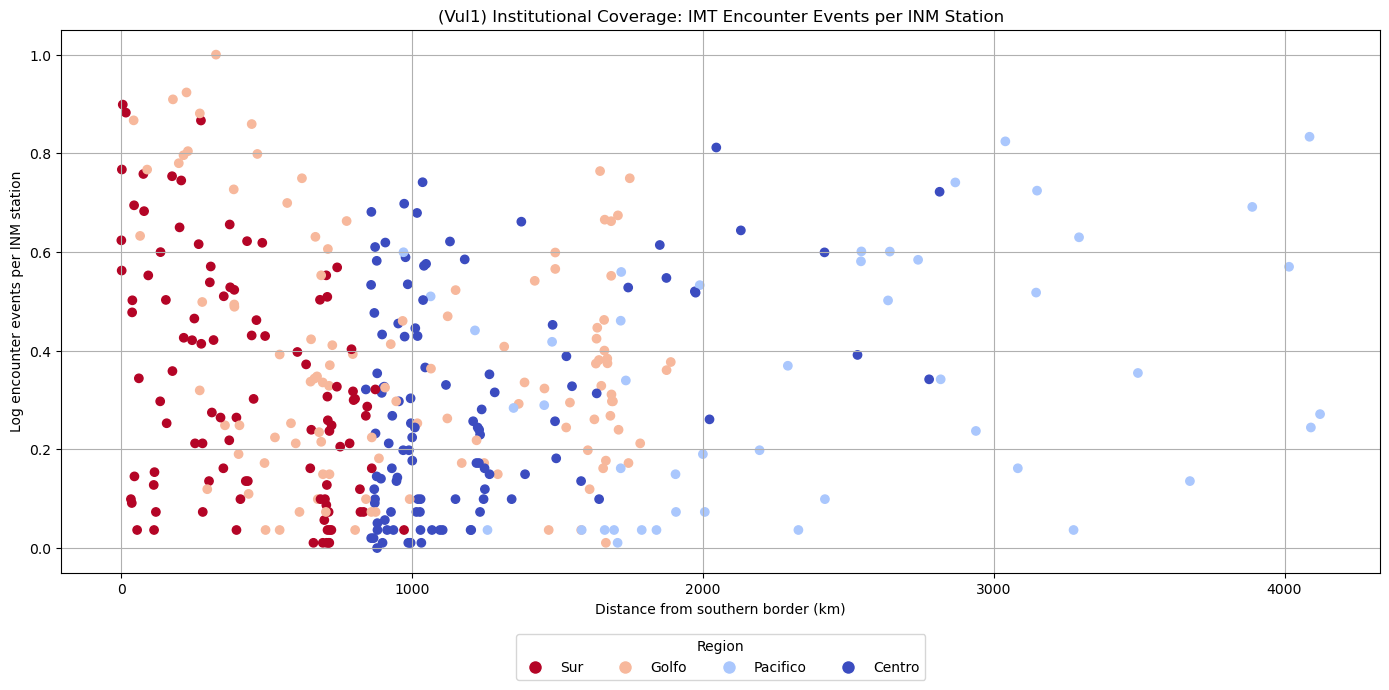

In [20]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura según sea necesario
plt.figure(figsize=(14, 7))

# Obtener los valores únicos de la columna 'region'
unique_routes = dfvalores['region'].unique()

# Crear un mapa de colores basado en el número de rutas únicas
colormap = plt.cm.get_cmap('coolwarm_r', len(unique_routes))

# Crear un diccionario para asignar un color a cada ruta
route_colors = {route: colormap(i) for i, route in enumerate(unique_routes)}

# Asignar colores a cada punto basado en su 'region'
colors = dfvalores['region'].map(route_colors)

# Graficar cada punto con el color correspondiente a su 'region'
plt.scatter(dfvalores['distancia_km'], dfvalores['norm_log_eventos_per_inm_30km'], 
            c=colors, marker='o', label='Data points colored by region')

# Añadir detalles al gráfico
plt.title('(Vul1) Institutional Coverage: IMT Encounter Events per INM Station')
plt.xlabel('Distance from southern border (km)')
plt.ylabel('Log encounter events per INM station')
plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Crear una leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10, label=route) for i, route in enumerate(unique_routes)]
plt.legend(handles=handles, title='Region', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(unique_routes))

# Ajustar el layout para evitar que la leyenda se corte
plt.tight_layout()

# Mostrar la gráfica
plt.show()


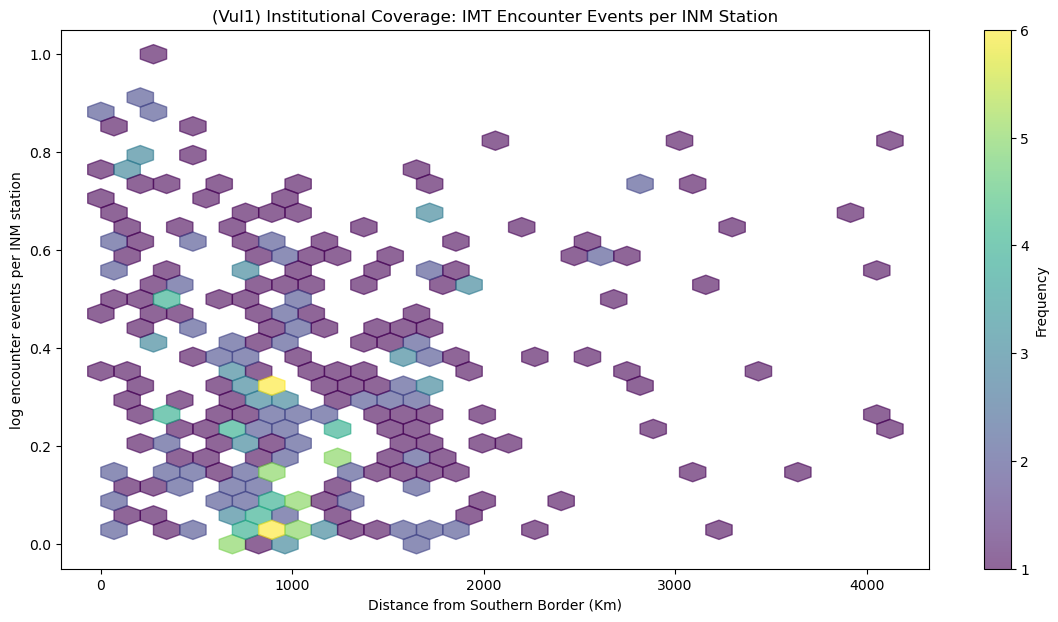

In [23]:
plt.figure(figsize=(14, 7))

# Añadir transparencia con el parámetro alpha
plt.hexbin(dfvalores['distancia_km'], dfvalores['norm_log_eventos_per_inm_30km'], gridsize=30, cmap='viridis', mincnt=1, alpha=0.6)
plt.colorbar(label='Frequency')
plt.title('(Vul1) Institutional Coverage: IMT Encounter Events per INM Station')
plt.xlabel('Distance from Southern Border (Km)')
plt.ylabel('log encounter events per INM station')
plt.show()


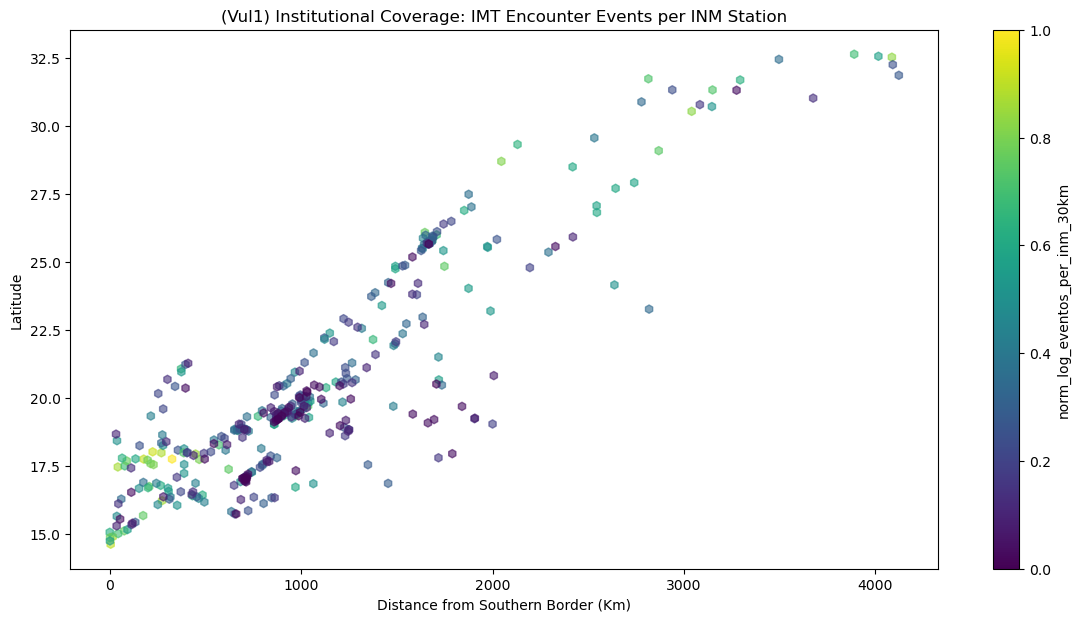

In [30]:
import matplotlib.pyplot as plt

# Crear la figura y el gráfico de dispersión con marcadores hexagonales
plt.figure(figsize=(14, 7))

# Normalizar el colorbar a los valores de 'norm_log_eventos_per_inm_30km'
norm = plt.Normalize(dfvalores['norm_log_eventos_per_inm_30km'].min(), dfvalores['norm_log_eventos_per_inm_30km'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Crear el scatter plot con marcadores hexagonales
plt.scatter(dfvalores['distancia_km'], dfvalores['latitud'], c=dfvalores['norm_log_eventos_per_inm_30km'], cmap='viridis', marker='h', alpha=0.6)
plt.colorbar(sm, label='norm_log_eventos_per_inm_30km')

plt.title('(Vul1) Institutional Coverage: IMT Encounter Events per INM Station')
plt.xlabel('Distance from Southern Border (Km)')
plt.ylabel('Latitude')
plt.show()


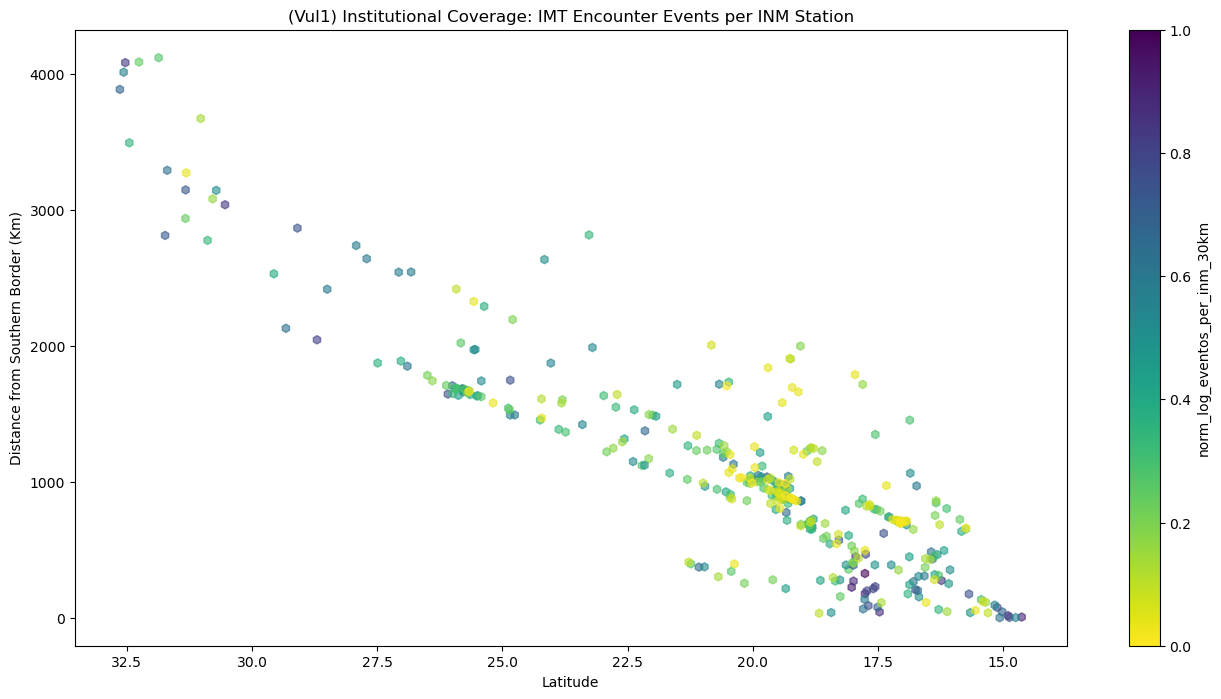

In [53]:
import matplotlib.pyplot as plt

# Crear la figura y el gráfico de dispersión con marcadores hexagonales
plt.figure(figsize=(16, 8))

# Normalizar el colorbar a los valores de 'norm_log_eventos_per_inm_30km'
norm = plt.Normalize(dfvalores['norm_log_eventos_per_inm_30km'].min(), dfvalores['norm_log_eventos_per_inm_30km'].max())
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
sm.set_array([])

# Crear el scatter plot con marcadores hexagonales
plt.scatter(dfvalores['latitud'], dfvalores['distancia_km'], c=dfvalores['norm_log_eventos_per_inm_30km'], cmap='viridis_r', marker='h', alpha=0.6)
plt.colorbar(sm, label='norm_log_eventos_per_inm_30km')

# Invertir el eje x
plt.gca().invert_xaxis()

plt.title('(Vul1) Institutional Coverage: IMT Encounter Events per INM Station')
plt.xlabel('Latitude')
plt.ylabel('Distance from Southern Border (Km)')
plt.show()




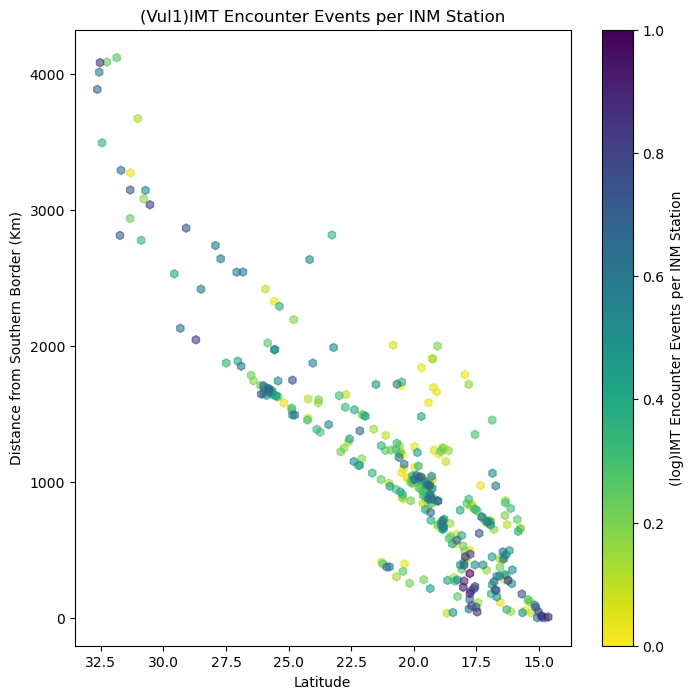

In [58]:
import matplotlib.pyplot as plt

# Ordenar el DataFrame por la columna 'norm_log_eventos_per_inm_30km' en orden ascendente
dfvalores_sorted = dfvalores.sort_values(by='norm_log_eventos_per_inm_30km')

# Crear la figura y el gráfico de dispersión con marcadores hexagonales
plt.figure(figsize=(8, 8))

# Normalizar el colorbar a los valores de 'norm_log_eventos_per_inm_30km'
norm = plt.Normalize(dfvalores_sorted['norm_log_eventos_per_inm_30km'].min(), dfvalores_sorted['norm_log_eventos_per_inm_30km'].max())
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
sm.set_array([])

# Crear el scatter plot con marcadores hexagonales
plt.scatter(dfvalores_sorted['latitud'], dfvalores_sorted['distancia_km'], c=dfvalores_sorted['norm_log_eventos_per_inm_30km'], cmap='viridis_r', marker='h', alpha=0.6)
plt.colorbar(sm, label='(log)IMT Encounter Events per INM Station')

# Invertir el eje x
plt.gca().invert_xaxis()

plt.title('(Vul1)IMT Encounter Events per INM Station')
plt.xlabel('Latitude')
plt.ylabel('Distance from Southern Border (Km)')
plt.show()


La métrica busca capturar la relación entre la cantidad de eventos de migrantes detectados y la capacidad institucional disponible para manejar esos eventos. Aquí detallo los aspectos clave de la métrica hasta el momento:

Definición Original de ICI:
Inicialmente, el ICI se definió como el número de eventos registrados por cada institución en un radio de 30 km (INM y SC), proporcionando un ratio directo que reflejaba la presión sobre los recursos institucionales disponibles.

Ajustes Realizados:
Transformación Logarítmica:
Propósito: Para manejar mejor la distribución asimétrica de los datos y evitar la influencia desproporcionada de valores extremos en la métrica.
Método: Se aplicó 
log
⁡
(
1
+
�
)
log(1+x) a los ratios para suavizar la variación y estabilizar la varianza en los datos.
Normalización Min-Max:
Propósito: Escalar los valores transformados a una escala de 0 a 1, facilitando la comparación entre municipios.
Método: Se normalizaron los valores ajustados de modo que el valor mínimo corresponde a 0 y el máximo a 1.
Corrección de Laplace:
Para abordar el caso de municipios sin instituciones, se añadió 1 a los conteos de instituciones (suavización de Laplace), permitiendo calcular ratios incluso en ausencia de instituciones y evitando divisiones por cero.

Interpretación de la Métrica de Vulnerabilidad:
Valores Cercanos a 1: Indican una alta vulnerabilidad, reflejando una mayor cantidad de eventos por institución después de los ajustes. Esto sugiere que las instituciones en estos municipios están potencialmente sobrecargadas o insuficientes para gestionar el volumen de eventos.
Valores Cercanos a 0: Indican una menor vulnerabilidad, sugiriendo que la relación entre eventos e instituciones es más manejable.
Valor de 0 en la Métrica Ajustada: Específicamente señala a municipios sin instituciones disponibles, destacando una situación de alta vulnerabilidad, ya que no hay capacidad institucional registrada para atender ningún evento.
Uso y Aplicaciones:
Esta métrica puede ser utilizada por autoridades y organizaciones para:

Identificar áreas críticas que requieren atención inmediata o reasignación de recursos.
Planificar de manera más efectiva la distribución de recursos y la implementación de políticas.
Monitorear y evaluar el impacto de intervenciones y mejoras en la infraestructura y servicios a lo largo del tiempo.
La vulnerabilidad, tal como se ha modelado hasta ahora, proporciona una herramienta cuantitativa para evaluar y comparar la capacidad de respuesta institucional frente a los flujos migratorios, permitiendo así una gestión más informada y focalizada de los recursos en el contexto de la migración irregular.

### Vulnerabilidad 2

Exposición a Zona de Riesgo es una métrica diseñada para cuantificar y visualizar la exposición de las rutas migratorias a zonas de alto riesgo, considerando tanto la distancia de las rutas a estas zonas como la capacidad institucional disponible para mitigar dicho riesgo.

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd


In [5]:
#segmentos = gpd.read_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp').to_crs(epsg=4485)
segmentos = gpd.read_file('C:\\Users\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\procesamiento de rutas\\arcos\\segmentos\\segmentos.shp').to_crs(epsg=4485)

In [158]:
#segmentos.to_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp')

/var/folders/68/6zkv8z4j4rl6ds90br2rb7ph0000gn/T/ipykernel_14640/242722420.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  segmentos.to_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp')


In [7]:
segmentos

,Arc,Ciudad,Tipo,Municipio,distancia_,duration_t,Corrupcion,CrimenOrg,CrimMujer,dist_ori,...,dur_ori,dur_des,institucio,vulnerabil,vulnerab_1,vulnerab_2,codigo_uni,distance_k,region,geometry
0,PG1529-PG1530,"Suchiate, Chiapas",origen,Suchiate,35.6,488.0,0.0,4.0,7.0,0.000,...,0.000000,472.916667,3.0,0.000359,0.000000,0.000359,S-PG1529-1,4.7,Sur,POINT (2552391.749 1704801.661)
1,PG1529-PG1530,0,intermedio,Frontera Hidalgo,35.6,488.0,0.0,1.0,1.0,18.038,...,245.083333,305.783333,0.0,0.000000,0.000000,0.000000,None,0.0,Desconocido,POINT (2554242.062 1718959.437)
2,PG1529-PG1530,"Tapachula, Chiapas",destino,Tapachula,35.6,488.0,6.0,67.0,122.0,35.561,...,487.933333,0.000000,19.0,0.000000,0.000845,0.000845,S-PG1530-8,11.8,Sur,POINT (2547519.579 1736173.639)
3,PG1530-PG1491,"Tapachula, Chiapas",origen,Tapachula,103.0,1377.0,6.0,67.0,122.0,0.000,...,0.000000,1388.733333,19.0,0.002464,0.000000,0.002464,S-PG1530-8,11.8,Sur,POINT (2547519.579 1736173.639)
4,PG1530-PG1491,0,intermedio,Acacoyagua,103.0,1377.0,0.0,0.0,0.0,84.140,...,1152.700000,451.766667,0.0,0.000000,0.000000,0.000000,None,0.0,Desconocido,POINT (2494615.767 1791183.781)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,PG1772-PG1694,0,intermedio,Tixkokob,158.0,2160.0,0.0,1.0,1.0,134.602,...,1808.100000,403.133333,0.0,0.000000,0.000000,0.000000,None,0.0,Desconocido,POINT (2788505.926 2479445.433)
1459,PG1772-PG1694,0,intermedio,Tixpéhual,158.0,2160.0,0.0,0.0,0.0,141.605,...,1903.233333,296.833333,0.0,0.000000,0.000000,0.000000,None,0.0,Desconocido,POINT (2779321.719 2476196.500)
1460,PG1772-PG1694,0,intermedio,Tunkás,158.0,2160.0,0.0,1.0,0.0,65.773,...,884.300000,1292.883333,0.0,0.000000,0.000000,0.000000,None,0.0,Desconocido,POINT (2858901.043 2478662.950)
1461,PG1772-PG1694,0,intermedio,Uayma,158.0,2160.0,0.0,0.0,0.0,22.664,...,306.683333,1832.633333,0.0,0.000000,0.000000,0.000000,None,0.0,Desconocido,POINT (2902989.682 2472589.015)


In [11]:
mun = gpd.read_file('C:\\Users\\puria\\Mapa_Migracion_Irregular_Mexico\\1. Mapas\\1. Mapas\\Metodo_1\\areas\\municipios\\municipiosshp.shp')

In [12]:
mun

,Entidad,Municipio,CveMunic,NOMEDO,NOMMUN,Area,Corrupcion,CrimenOrg,Violencia,geometry
0,Aguascalientes,Aguascalientes,1001,Aguascalientes,Aguascalientes,1168.762384,474.0,1462.0,1011.0,"POLYGON ((-102.14207 22.07321, -102.12842 22.0..."
1,Aguascalientes,Asientos,1002,Aguascalientes,Asientos,547.762077,4.0,108.0,28.0,"POLYGON ((-102.12322 22.28697, -102.11973 22.2..."
2,Aguascalientes,Calvillo,1003,Aguascalientes,Calvillo,931.300088,9.0,54.0,27.0,"POLYGON ((-102.80641 21.99334, -102.80511 21.9..."
3,Aguascalientes,Cosío,1004,Aguascalientes,Cosio,128.907513,1.0,31.0,8.0,"POLYGON ((-102.29781 22.45899, -102.29616 22.4..."
4,Aguascalientes,El Llano,1010,Aguascalientes,El Llano,500.861359,7.0,14.0,8.0,"POLYGON ((-102.09788 22.02335, -102.08893 22.0..."
...,...,...,...,...,...,...,...,...,...,...
2475,Zacatecas,Villa González Ortega,32053,Zacatecas,Villa Gonzalez Ortega,417.529939,0.0,1.0,4.0,"POLYGON ((-101.94625 22.64974, -101.94875 22.6..."
2476,Zacatecas,Villa Hidalgo,32054,Zacatecas,Villa Hidalgo,355.528477,1.0,1.0,1.0,"POLYGON ((-101.65688 22.50250, -101.65540 22.4..."
2477,Zacatecas,Villa de Cos,32051,Zacatecas,Villa de Cos,6405.541210,2.0,2.0,13.0,"POLYGON ((-102.72540 23.78805, -102.72054 23.7..."
2478,Zacatecas,Villanueva,32055,Zacatecas,Villanueva,2158.696446,9.0,9.0,15.0,"POLYGON ((-102.78672 22.67556, -102.77979 22.6..."


In [9]:
segmentos.columns

Index(['Arc', 'Ciudad', 'Tipo', 'Municipio', 'distancia_', 'duration_t',
       'Corrupcion', 'CrimenOrg', 'CrimMujer', 'dist_ori', 'dist_des',
       'inm_30km', 'sc_30km', 'dur_ori', 'dur_des', 'institucio', 'vulnerabil',
       'vulnerab_1', 'vulnerab_2', 'codigo_uni', 'distance_k', 'region',
       'geometry'],
      dtype='object')

In [186]:
#print(segmentos)

In [177]:
# Eliminar las columnas especificadas del DataFrame 'segmentos'
columnas_a_eliminar = ['vulnerabilidad_origen','vulnerabilidad_destino']
segmentos = segmentos.drop(columns=columnas_a_eliminar)

In [255]:
segmentos.columns

Index(['Arc', 'Ciudad', 'Tipo', 'Municipio', 'distancia_', 'duration_t',
       'Corrupcion', 'CrimenOrg', 'CrimMujer', 'dist_ori', 'dist_des',
       'inm_30km', 'sc_30km', 'dur_ori', 'dur_des', 'codigo_uni', 'geometry',
       'distance_km', 'region', 'vul2_crimmujer_or', 'vul2_crimmujer_des',
       'vul2_crimenorg_or', 'vul2_crimenorg_des', 'vul2_corrupcion_or',
       'vul2_corrupcion_des'],
      dtype='object')

In [183]:
# Calcular la suma de las distancias totales de todos los arcos
suma_distancia_total = segmentos['distancia_'].sum()

# Función para calcular la vulnerabilidad para cada nodo y tipo de crimen
def calcular_vulnerabilidad(df, tipo_nodo, suma_distancia_total, columna_crimen):
    vulnerabilidad = []
    for idx, row in df.iterrows():
        if row['Tipo'] == tipo_nodo:
            arc = row['Arc']
            nodo = row['Ciudad']
            instituciones_nodo = row['sc_30km'] + 1
            distancia_total_arco = row['distancia_']
            
            df_arco = df[df['Arc'] == arc]
            
            crimen_dista_nodo = sum(
                (p[columna_crimen] / (p[f'dist_{tipo_nodo[:3]}'] + 1))
                for i, p in df_arco.iterrows()
            )
            
            vulnerabilidad_nodo = (crimen_dista_nodo * (distancia_total_arco / suma_distancia_total) * (1 / (instituciones_nodo + 1)))
            vulnerabilidad.append(vulnerabilidad_nodo)
        else:
            vulnerabilidad.append(0)
    return vulnerabilidad

# Calcular vulnerabilidad para nodos de origen y destino para cada tipo de crimen
for crimen in ['CrimMujer', 'CrimenOrg', 'Corrupcion']:
    segmentos[f'vul2_{crimen.lower()}_or'] = calcular_vulnerabilidad(segmentos, 'origen', suma_distancia_total, crimen)
    segmentos[f'vul2_{crimen.lower()}_des'] = calcular_vulnerabilidad(segmentos, 'destino', suma_distancia_total, crimen)

# Mostrar el DataFrame con las nuevas columnas de vulnerabilidad
print(segmentos[['Arc', 'Ciudad', 'Tipo', 'vul2_crimmujer_or', 'vul2_crimmujer_des', 'vul2_crimenorg_or', 'vul2_crimenorg_des', 'vul2_corrupcion_or', 'vul2_corrupcion_des']])



                Arc              Ciudad        Tipo  vul2_crimmujer_or  \
0     PG1529-PG1530   Suchiate, Chiapas      origen           0.000287   
1     PG1529-PG1530                   0  intermedio           0.000000   
2     PG1529-PG1530  Tapachula, Chiapas     destino           0.000000   
3     PG1530-PG1491  Tapachula, Chiapas      origen           0.002594   
4     PG1530-PG1491                   0  intermedio           0.000000   
...             ...                 ...         ...                ...   
1458  PG1772-PG1694                   0  intermedio           0.000000   
1459  PG1772-PG1694                   0  intermedio           0.000000   
1460  PG1772-PG1694                   0  intermedio           0.000000   
1461  PG1772-PG1694                   0  intermedio           0.000000   
1462  PG1772-PG1694     Merida, Yucatan     destino           0.000000   

      vul2_crimmujer_des  vul2_crimenorg_or  vul2_crimenorg_des  \
0               0.000000           0.000163 

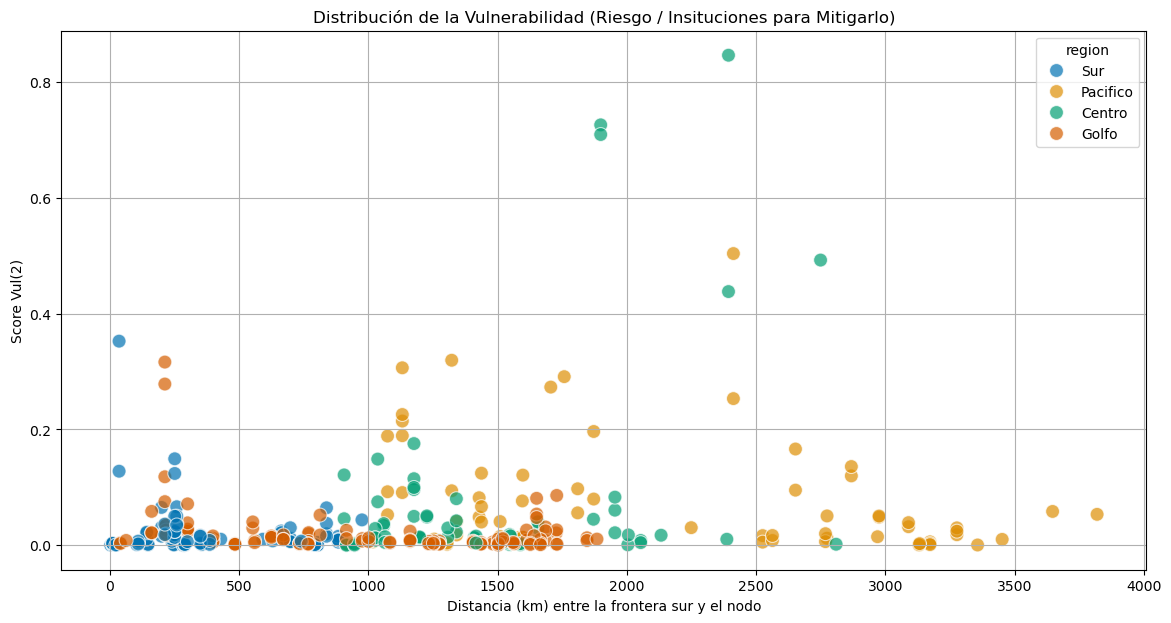

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar el DataFrame para excluir las filas donde 'region' es 'Desconocido'
segmentos_filtrado = segmentos[segmentos['region'] != 'Desconocido']

# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear el scatter plot utilizando seaborn para un manejo fácil de los colores por categoría
sns.scatterplot(data=segmentos_filtrado, x='distance_k', y='vulnerab_2', hue='region', palette='colorblind', s=100, alpha=0.7)

# Añadir detalles al gráfico
plt.title('Distribución de la Vulnerabilidad (Riesgo / Insituciones para Mitigarlo)')
plt.xlabel('Distancia (km) entre la frontera sur y el nodo')
plt.ylabel('Score Vul(2)')
plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Mostrar la gráfica
plt.show()



In [ ]:
# Crear una nueva columna que contenga la suma de las columnas especificadas
segmentos['vul_total'] = (segmentos['vul2_crimmujer_or'] + segmentos['vul2_crimmujer_des'] +
                          segmentos['vul2_crimenorg_or'] + segmentos['vul2_crimenorg_des'] +
                          segmentos['vul2_corrupcion_or'] + segmentos['vul2_corrupcion_des'])

# Filtrar los datos para omitir los que tienen 'Desconocido' en la columna 'region'
segmentos_filtered = segmentos[segmentos['region'] != 'Desconocido']

In [15]:
#arc_df = pd.read_csv("/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/arcos_rutas_a_pie.csv")
#arc_df.head()

## Resultados Ambas Metricas

In [272]:
# Agrupar por 'Ciudad' y sumar 'vul_total', manteniendo las columnas especificadas
segmentos_agg = segmentos_filtered.groupby('Ciudad').agg({
    'Municipio': 'first',     # Mantener el primer valor de 'Municipio'
    'distancia_': 'first',    # Mantener el primer valor de 'distancia_'
    'duration_t': 'first',    # Mantener el primer valor de 'duration_t'
    'Corrupcion': 'first',    # Mantener el primer valor de 'Corrupcion'
    'CrimenOrg': 'first',     # Mantener el primer valor de 'CrimenOrg'
    'CrimMujer': 'first',     # Mantener el primer valor de 'CrimMujer'
    'geometry': 'first',      # Mantener el primer valor de 'geometry'
    'distance_km': 'first',   # Mantener el primer valor de 'distance_km'
    'region': 'first',        # Mantener el primer valor de 'region'
    'vul_total': 'sum'        # Sumar los valores de 'vul_total'
}).reset_index()

# Crear un GeoDataFrame a partir del DataFrame resultante
segmentos_agg_gdf = gpd.GeoDataFrame(segmentos_agg, geometry='geometry')


In [287]:
dfvalores_filtered.head()

,nombre,Ciudad,estado,geometry_xy,region,ID_Poligono,codigo_unico,eventos,eventos_in_grid,inm_30km,...,inm_in_estado,sc_30km,sc_in_grid,sc_in_estado,distance_km,rellenado,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,eventos_per_inm_30km,inm_30km_adjusted
0,"Tapachula, Chiapas","Tapachula, Chiapas",Chiapas,POINT (-92.2609265 14.9042905),Sur,PG1530,S-PG1530-8,98486,142180,2,...,13,17,11,35,11.8,False,10.399088,0.902790,5.748840,3
1,"Huimanguillo, Tabasco","Huimanguillo, Tabasco",Tabasco,POINT (-93.6634408051158 17.7620967),Golfo,PG1456,G-PG1456-1,97523,97523,0,...,3,0,0,0,302.0,False,11.487854,1.000000,inf,1
2,"Centro, Tabasco","Centro, Tabasco",Tabasco,POINT (-92.7747911804616 18.0271588),Golfo,PG1495,G-PG1495-6,71661,92612,1,...,3,0,0,0,214.0,False,10.486583,0.910602,11.179716,2
3,"Acayucan, Veracruz","Acayucan, Veracruz",Veracruz,POINT (-94.9145752 17.9487862),Golfo,PG1378,G-PG1378-4,45794,45863,1,...,3,2,2,12,485.0,False,10.038805,0.870623,10.731930,2
4,"Tenosique, Tabasco","Tenosique, Tabasco",Tabasco,POINT (-91.4220212 17.4707129),Golfo,PG1572,G-PG1572-3,40069,55739,1,...,3,2,5,0,42.2,False,9.905261,0.858699,10.598383,2


In [277]:
# Filter dfvalores to keep only the rows where 'Ciudad' values also appear in segmentos_agg_gdf
dfvalores_filtered = dfvalores[dfvalores['Ciudad'].isin(segmentos_agg_gdf['Ciudad'])]

# Ensure the lengths match
print(len(dfvalores_filtered), len(segmentos_agg_gdf))

149 149


In [288]:
# Merge the 'eventos_per_inm_30km' column from dfvalores_filtered to segmentos_agg_gdf
segmentos_agg_gdf = segmentos_agg_gdf.merge(dfvalores_filtered[['Ciudad', 'norm_log_eventos_per_inm_30km']], on='Ciudad', how='left')


In [289]:
segmentos_agg_gdf.head()

,Ciudad,Municipio,distancia_,duration_t,Corrupcion,CrimenOrg,CrimMujer,geometry,distance_km,region,vul_total,eventos_per_inm_30km,norm_log_eventos_per_inm_30km
0,"Acapulco de Juarez, Guerrero",Acapulco de Juarez,131.000000,1740.0,81.0,360.0,351.0,POINT (1689223.031 1898706.393),1075.0000,Pacifico,0.501566,inf,0.286498
1,"Acayucan, Veracruz",Acayucan,100.000000,1358.0,20.0,23.0,17.0,POINT (2221815.615 2060430.595),485.0000,Golfo,0.026361,10.731930,0.870623
2,"Acuna, Coahuila",Acuna,89.479304,1209.0,26.0,549.0,146.0,POINT (1480152.039 3286434.352),2132.3755,Centro,0.064116,inf,0.637016
3,"Agua Dulce, Veracruz",Agua Dulce,212.000000,2880.0,3.0,11.0,13.0,POINT (2302695.350 2084117.160),400.0000,Golfo,0.039949,inf,0.718023
4,"Agua Prieta, Sonora",Agua Prieta,162.000000,2220.0,7.0,4.0,95.0,POINT (637340.698 3467136.877),2969.2323,Pacifico,0.016376,3.583519,0.234826


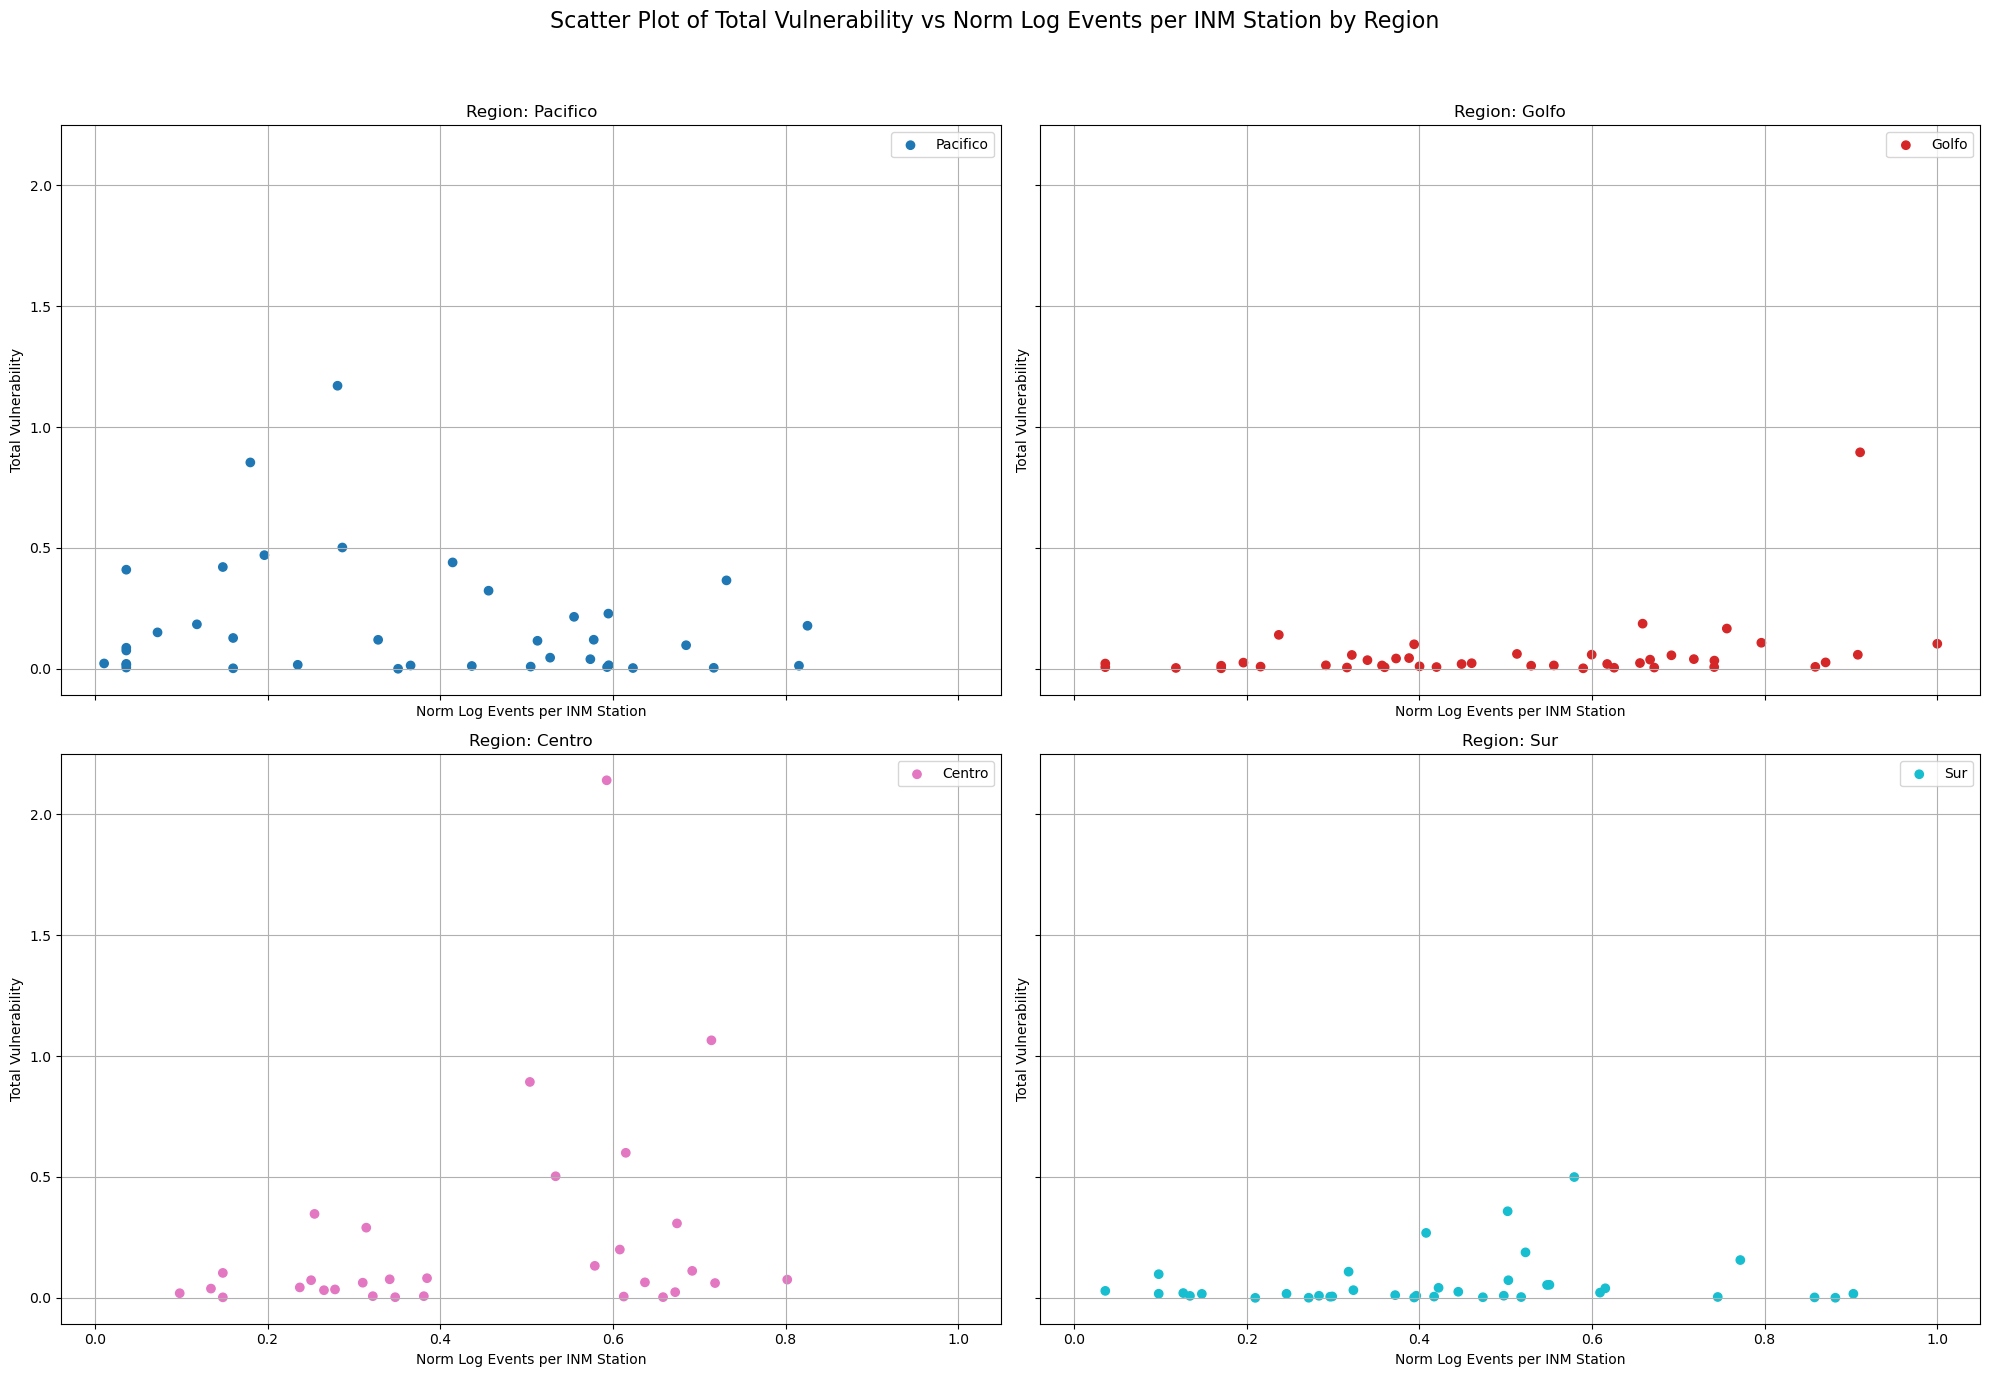

In [295]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener los valores únicos de la columna 'region'
unique_regions = segmentos_agg_gdf['region'].unique()

# Configurar el tamaño de la figura según sea necesario
fig, axes = plt.subplots(2, 2, figsize=(20, 14), sharex=True, sharey=True)
axes = axes.flatten()

# Crear un diccionario para asignar un color a cada región
colormap = plt.cm.get_cmap('tab10', len(unique_regions))
region_colors = {region: colormap(i) for i, region in enumerate(unique_regions)}

# Iterar sobre cada región única y crear un scatter plot
for i, region in enumerate(unique_regions):
    ax = axes[i]
    region_data = segmentos_agg_gdf[segmentos_agg_gdf['region'] == region]
    
    # Crear el scatter plot para la región actual
    ax.scatter(region_data['norm_log_eventos_per_inm_30km'], region_data['vul_total'], 
               c=[region_colors[region]]*len(region_data), marker='o', label=region)
    
    # Añadir detalles al gráfico
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Norm Log Events per INM Station')
    ax.set_ylabel('Total Vulnerability')
    ax.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad
    ax.legend()

# Añadir un título general para la figura
fig.suptitle('Scatter Plot of Total Vulnerability vs Norm Log Events per INM Station by Region', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para evitar que los títulos se corten

# Mostrar la gráfica
plt.show()
